##      **Traffic Sign Detection**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Traffic Sign Detection" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification
!unzip traffic-sign-dataset-classification.zip -d traffic_sign_dataset

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0040.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0041.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0042.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0043.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0044.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0045.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0046.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0047.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0048.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/24/024_1_0049.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/25/025_0001.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/25/025_1_0001.png  
  inflating: traffic_sign_dataset/traffic_Data/DATA/26/026_0001.png  
  inflating: traf

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv and test_data.csv file with columns image_path and label for further processing:-


In [3]:
import os
import pandas as pd

train_dir = '/content/traffic_sign_dataset/traffic_Data/DATA'

image_paths = []
labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(label_dir, image_name)
                image_paths.append(image_path)
                labels.append(label)

data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

csv_file_path = '/content/traffic_sign_dataset/traffic_Data/train_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV train file saved successfully!")

CSV train file saved successfully!


In [4]:
import os
import pandas as pd

test_folder = '/content/traffic_sign_dataset/traffic_Data/TEST'

image_paths = []
labels = []

# Iterate through each image file in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(test_folder, image_name)
        image_paths.append(image_path)
        labels.append('Unknown')

df = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

csv_file_path = '/content/traffic_sign_dataset/traffic_Data/test_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV test file saved successfully!")

CSV test file saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , VGG16 and ResNet50 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception  , ResNet50 , VGG16
from keras import layers, models, optimizers


# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/traffic_sign_dataset/traffic_Data/train_data.csv')

# Convert the 'Label' column to a categorical data type
df['Label'] = df['Label'].astype('str')

# Perform stratified split manually to ensure all classes are present in both sets
train_list = []
val_list = []

for label in df['Label'].unique():
    class_subset = df[df['Label'] == label]
    train_class, val_class = train_test_split(class_subset, test_size=0.2, random_state=42)
    train_list.append(train_class)
    val_list.append(val_class)

# Concatenate all class splits to form the final train and validation DataFrames
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)

# Check the data type of the 'Label' column in the train and validation DataFrames
print(train_df['Label'].dtype)
print(val_df['Label'].dtype)
num_classes = len(df['Label'].unique())
print(num_classes)

# Check the number of classes in each set
print("Training set classes:", len(train_df['Label'].unique()))
print("Validation set classes:", len(val_df['Label'].unique()))

object
object
58
Training set classes: 58
Validation set classes: 58


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

In [8]:

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 3313 validated image filenames belonging to 58 classes.
Found 857 validated image filenames belonging to 58 classes.


# Exploratory Data Analysis

In [9]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                          Image_Path Label
0  /content/traffic_sign_dataset/traffic_Data/DAT...    30
1  /content/traffic_sign_dataset/traffic_Data/DAT...    30
2  /content/traffic_sign_dataset/traffic_Data/DAT...    30
3  /content/traffic_sign_dataset/traffic_Data/DAT...    30
4  /content/traffic_sign_dataset/traffic_Data/DAT...    30
(3313, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  3313 non-null   object
 1   Label       3313 non-null   object
dtypes: object(2)
memory usage: 51.9+ KB
None
                                               Image_Path Label
count                                                3313  3313
unique                                               3313    58
top     /content/traffic_sign_dataset/traffic_Data/DAT...    28
freq                                                    1   356


In [14]:
print(train_df)

                                             Image_Path Label Label_Int
0     /content/traffic_sign_dataset/traffic_Data/DAT...    30       NaN
1     /content/traffic_sign_dataset/traffic_Data/DAT...    30       NaN
2     /content/traffic_sign_dataset/traffic_Data/DAT...    30       NaN
3     /content/traffic_sign_dataset/traffic_Data/DAT...    30       NaN
4     /content/traffic_sign_dataset/traffic_Data/DAT...    30       NaN
...                                                 ...   ...       ...
3308  /content/traffic_sign_dataset/traffic_Data/DAT...     4       NaN
3309  /content/traffic_sign_dataset/traffic_Data/DAT...     4       NaN
3310  /content/traffic_sign_dataset/traffic_Data/DAT...     4       NaN
3311  /content/traffic_sign_dataset/traffic_Data/DAT...     4       NaN
3312  /content/traffic_sign_dataset/traffic_Data/DAT...     4       NaN

[3313 rows x 3 columns]


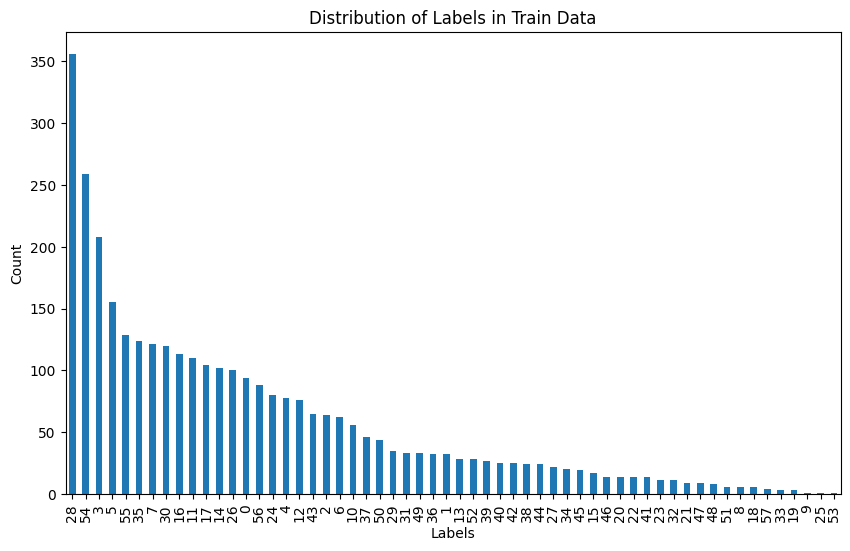

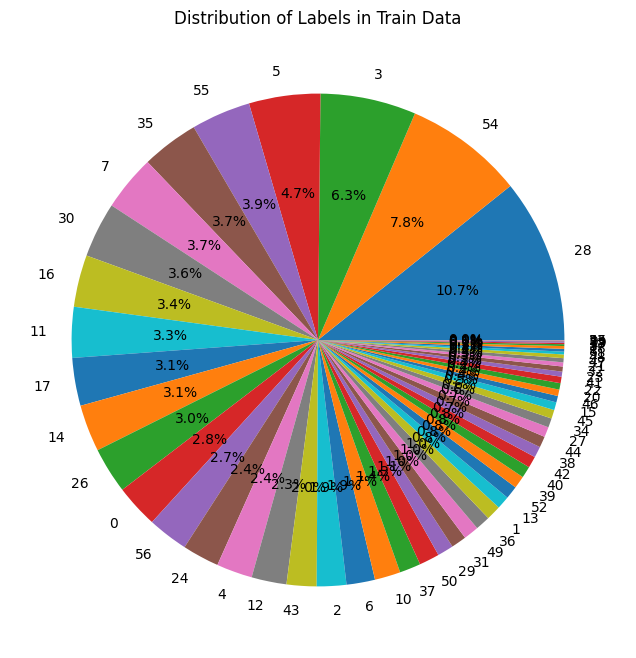

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame into train_df

# Plotting a bar graph
plt.figure(figsize=(10, 6))
train_df['Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in Train Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Labels in Train Data')
plt.ylabel('')
plt.show()

Number of unique image paths: 3313


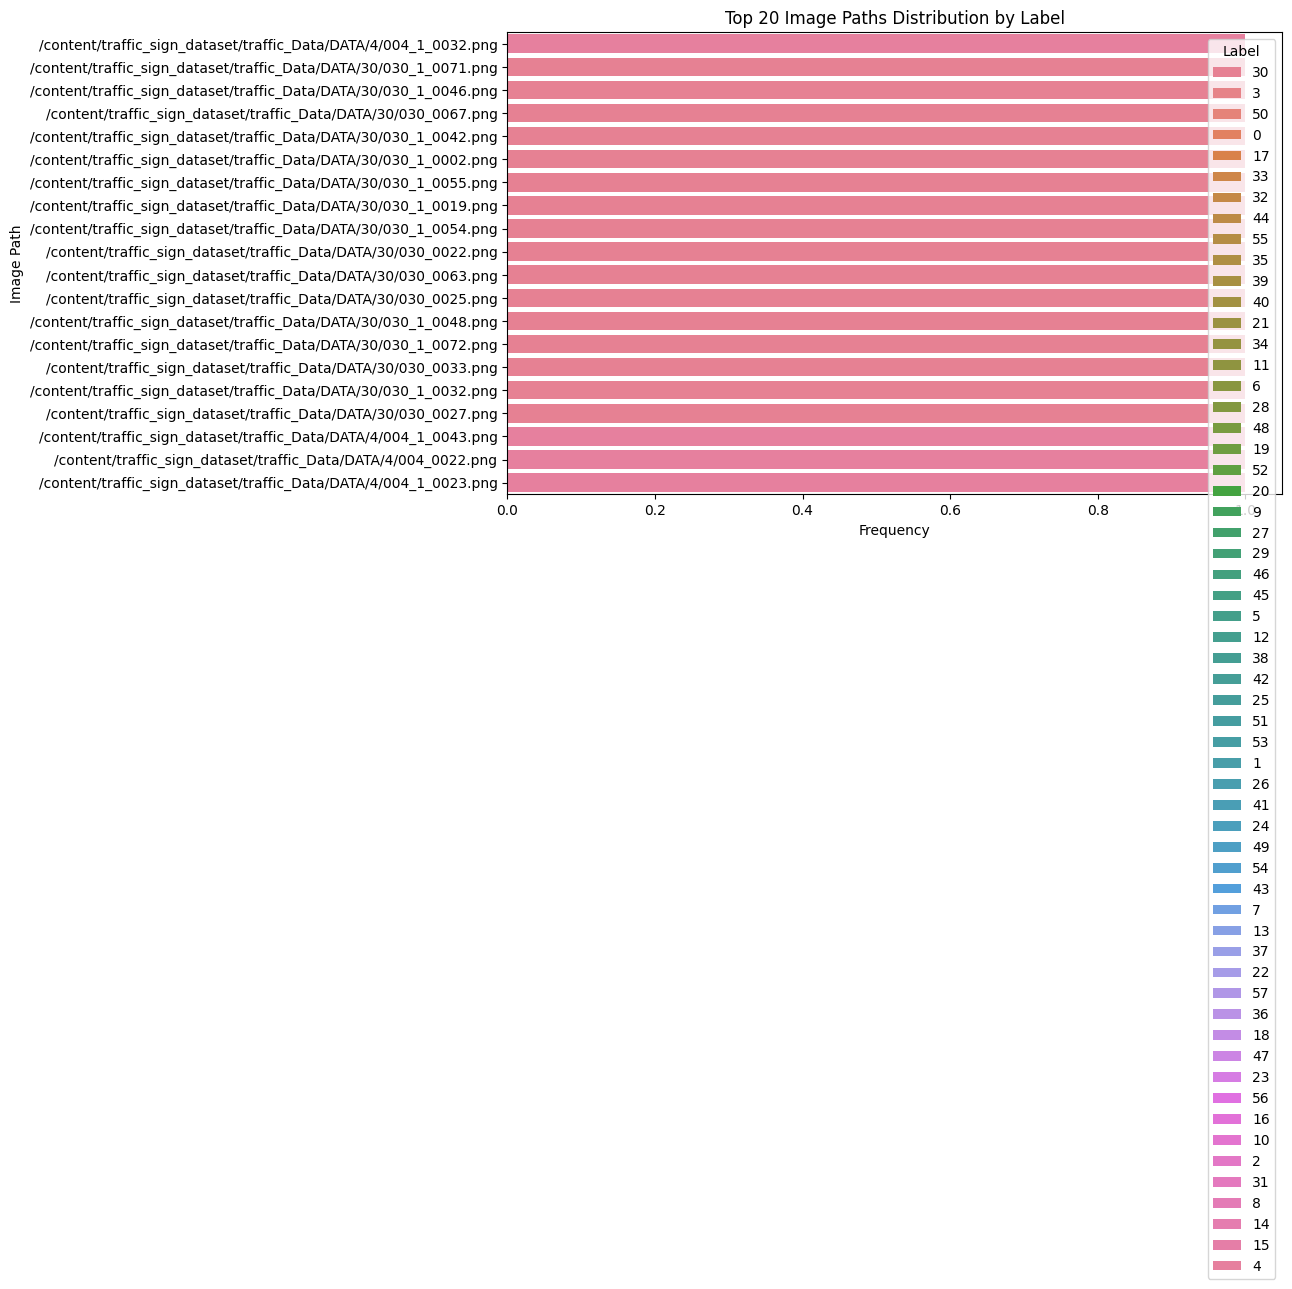

Column Image_Path has 3313 unique values.
Column Label has 58 unique values.


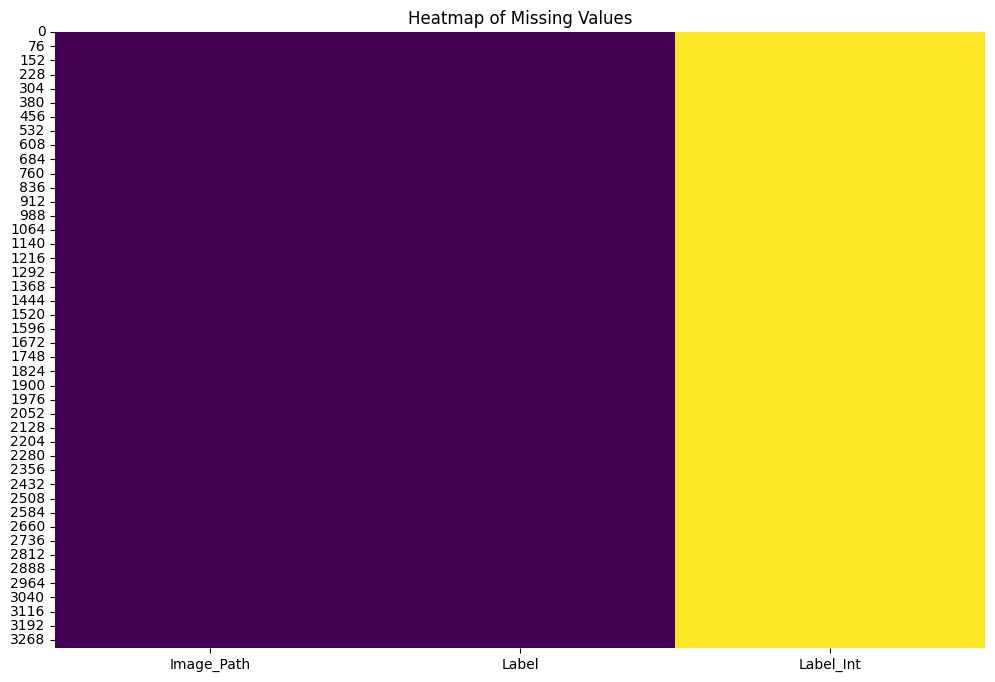

Label
28    356
54    259
3     208
5     155
55    129
35    124
7     121
30    120
16    113
11    110
17    104
14    102
26    100
0      94
56     88
24     80
4      78
12     76
43     65
2      64
6      62
10     56
37     46
50     44
29     35
31     33
49     33
36     32
1      32
13     28
52     28
39     27
40     25
42     25
38     24
44     24
27     22
34     20
45     19
15     17
46     14
20     14
22     14
41     14
23     11
32     11
21      9
47      9
48      8
51      6
8       6
18      6
57      4
33      3
19      3
9       1
25      1
53      1
Name: count, dtype: int64


In [19]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [20]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path       0
Label            0
Label_Int     3313
dtype: int64
0


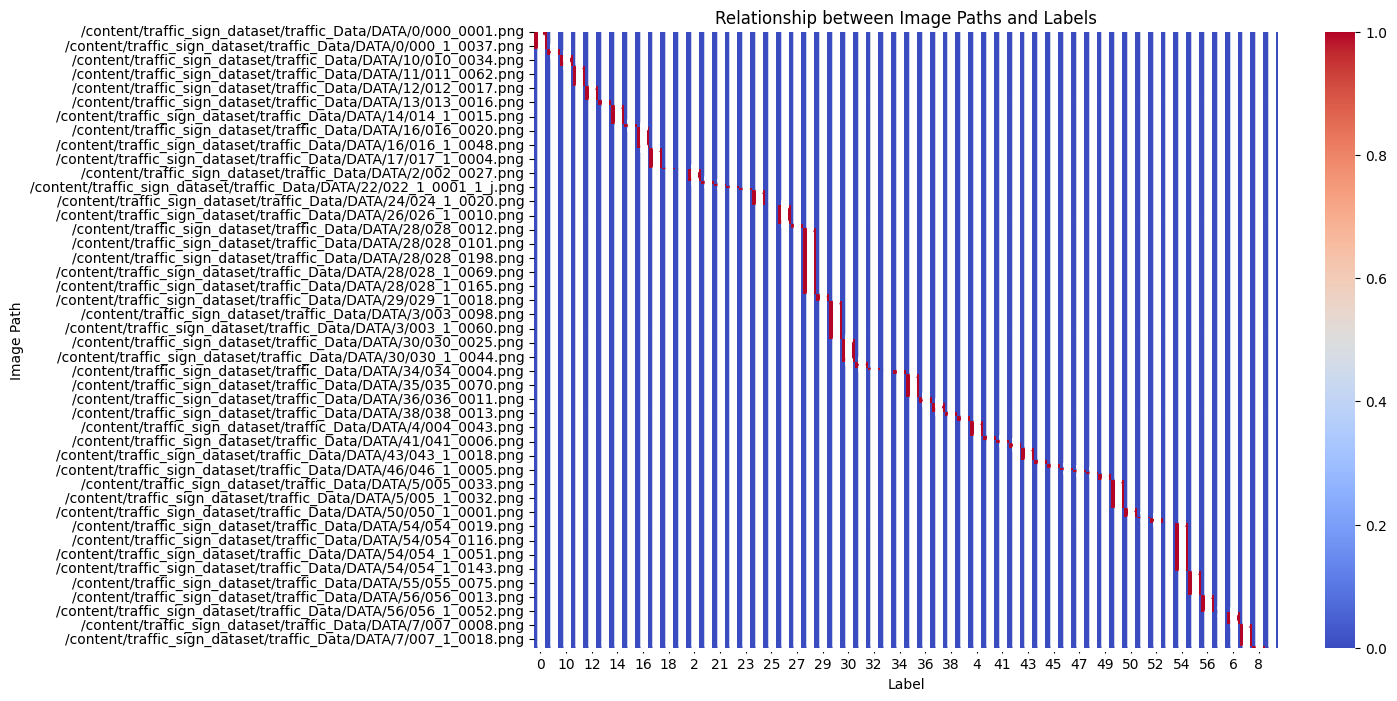

In [21]:
# Create a cross-tabulation or contingency table
cross_tab = pd.crosstab(train_df['Image_Path'], train_df['Label'])

# Plotting the heatmap for the cross-tabulation
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Relationship between Image Paths and Labels')
plt.xlabel('Label')
plt.ylabel('Image Path')
plt.show()

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

In [ ]:
# List of base models with their respective input shapes
base_models = [
    (ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50'),
    (VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'VGG16'),
    (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]

83683744/83683744 [==============================] - 5s 0us/step


# Customizing it according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [ ]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D

from keras.layers import Dropout

def create_model(base_model, input_shape, num_classes):
    base_model.trainable = True  # Unfreeze the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the specified number of epochs
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=epochs,
                        callbacks=[early_stopping])

    # Evaluate the model
    val_accuracy = history.history['val_accuracy'][-1]
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    return history

Training ResNet50...
Epoch 1/15
104/104 [==============================] - 104s 625ms/step - loss: 2.4597 - accuracy: 0.4177 - val_loss: 3.9851 - val_accuracy: 0.0327
Epoch 2/15
104/104 [==============================] - 61s 587ms/step - loss: 0.8756 - accuracy: 0.7950 - val_loss: 4.0643 - val_accuracy: 0.0222
Epoch 3/15
104/104 [==============================] - 60s 576ms/step - loss: 0.4696 - accuracy: 0.8889 - val_loss: 4.0677 - val_accuracy: 0.0058
Epoch 4/15
104/104 [==============================] - 61s 584ms/step - loss: 0.3296 - accuracy: 0.9191 - val_loss: 3.9638 - val_accuracy: 0.0968
Epoch 5/15
104/104 [==============================] - 59s 569ms/step - loss: 0.2368 - accuracy: 0.9430 - val_loss: 2.9536 - val_accuracy: 0.4446
Epoch 6/15
104/104 [==============================] - 60s 574ms/step - loss: 0.1799 - accuracy: 0.9529 - val_loss: 1.7028 - val_accuracy: 0.6628
Epoch 7/15
104/104 [==============================] - 60s 573ms/step - loss: 0.1362 - accuracy: 0.9632 - val

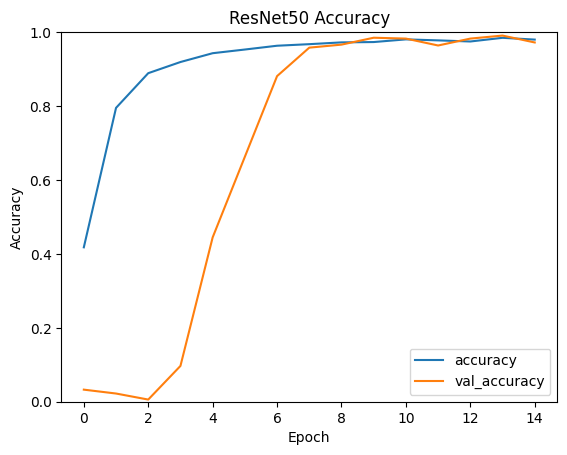

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet50 model to saved_models/ResNet50_saved.h5
Training VGG16...
Epoch 1/13
104/104 [==============================] - 107s 786ms/step - loss: 3.9469 - accuracy: 0.0531 - val_loss: 3.6247 - val_accuracy: 0.1050
Epoch 2/13
104/104 [==============================] - 63s 601ms/step - loss: 3.4320 - accuracy: 0.1561 - val_loss: 3.0663 - val_accuracy: 0.2474
Epoch 3/13
104/104 [==============================] - 64s 610ms/step - loss: 2.9817 - accuracy: 0.2584 - val_loss: 2.5429 - val_accuracy: 0.3209
Epoch 4/13
104/104 [==============================] - 64s 608ms/step - loss: 2.5401 - accuracy: 0.3317 - val_loss: 2.2128 - val_accuracy: 0.3734
Epoch 5/13
104/104 [==============================] - 64s 613ms/step - loss: 2.1630 - accuracy: 0.4280 - val_loss: 1.7598 - val_accuracy: 0.5636
Epoch 6/13
104/104 [==============================] - 64s 605ms/step - loss: 1.8319 - accuracy: 0.5077 - val_loss: 1.3744 - val_accuracy: 0.6336
Epoch 7/13
104/104 [==============================] - 64

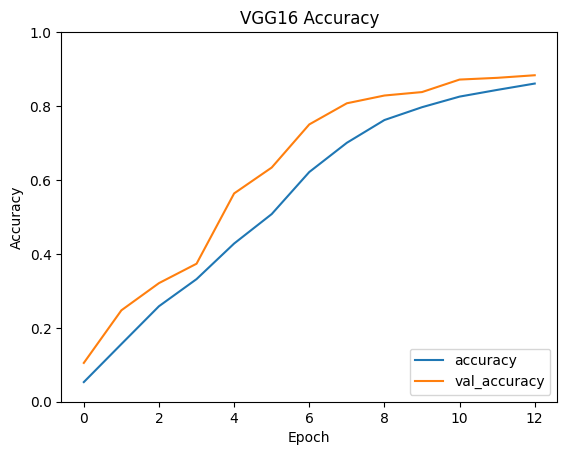

Saved VGG16 model to saved_models/VGG16_saved.h5
Training Xception...
Epoch 1/13
104/104 [==============================] - 111s 771ms/step - loss: 2.9143 - accuracy: 0.3030 - val_loss: 1.5853 - val_accuracy: 0.6348
Epoch 2/13
104/104 [==============================] - 67s 637ms/step - loss: 1.1721 - accuracy: 0.7383 - val_loss: 0.6205 - val_accuracy: 0.8448
Epoch 3/13
104/104 [==============================] - 68s 649ms/step - loss: 0.6112 - accuracy: 0.8648 - val_loss: 0.3658 - val_accuracy: 0.9125
Epoch 4/13
104/104 [==============================] - 68s 654ms/step - loss: 0.3677 - accuracy: 0.9146 - val_loss: 0.2173 - val_accuracy: 0.9358
Epoch 5/13
104/104 [==============================] - 68s 653ms/step - loss: 0.2485 - accuracy: 0.9402 - val_loss: 0.1624 - val_accuracy: 0.9510
Epoch 6/13
104/104 [==============================] - 68s 652ms/step - loss: 0.1969 - accuracy: 0.9547 - val_loss: 0.1189 - val_accuracy: 0.9662
Epoch 7/13
104/104 [==============================] - 68s 6

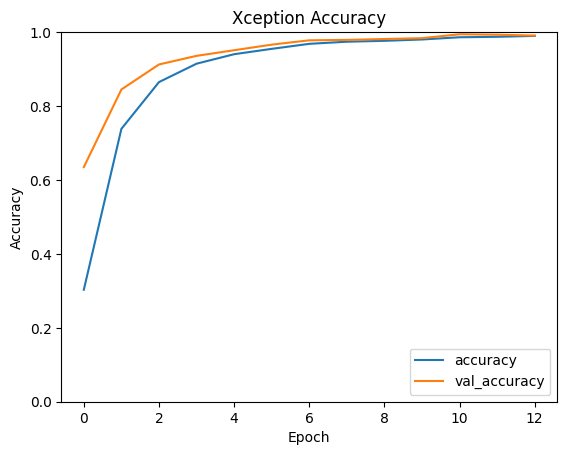

Saved Xception model to saved_models/Xception_saved.h5


In [ ]:
# Directory to save the models
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Adjustments for ResNet50
# Train and evaluate each model
histories = {}
for base_model, input_shape, model_name in base_models:
    # Resize data if necessary (dummy data, so not applicable here)
    if input_shape != (224, 224, 3):
        # Resize X_train and X_val to the required input_shape
        # This is just a placeholder, implement actual resizing if needed
        pass

    # Create the model
    model = create_model(base_model, input_shape, num_classes)

    if model_name == 'ResNet50':
        # Unfreeze more layers for ResNet50 and adjust learning rate
        for layer in model.layers[-30:]:
            layer.trainable = True
        epochs = 15
        optimizer = optimizers.Adam(learning_rate=0.0001)
    else:
        epochs = 13
        optimizer = optimizers.Adam()

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(f'Training {model_name}...')
    history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=epochs)
    histories[model_name] = history

    # Saving the model after training
    model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
    print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

# Testing and labeling unseen data

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image

# Load test dataset
test_df = pd.read_csv('/content/traffic_sign_dataset/traffic_Data/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'Label': prediction_labels,
        })

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")

1/1 [==============================] - 1s 1s/step
Predictions saved to /content/saved_models/predicted_ResNet50_saved.csv
1/1 [==============================] - 0s 149ms/step
Predictions saved to /content/saved_models/predicted_VGG16_saved.csv
1/1 [==============================] - 1s 1s/step
Predictions saved to /content/saved_models/predicted_Xception_saved.csv


# image label and prediction and visualization

Predictions using model: ResNet50_saved


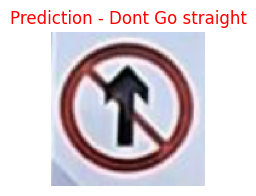

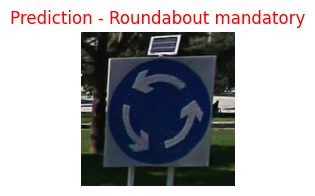

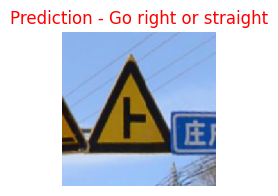

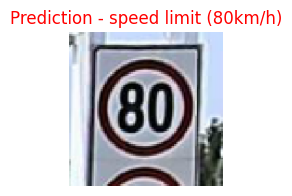

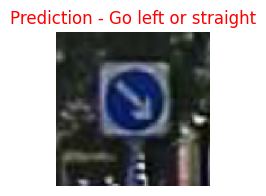

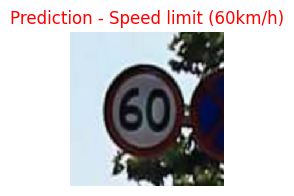

Predictions using model: VGG16_saved


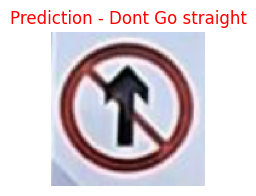

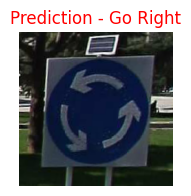

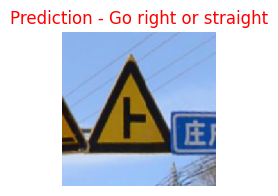

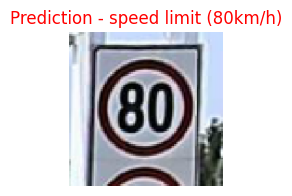

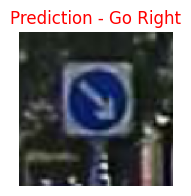

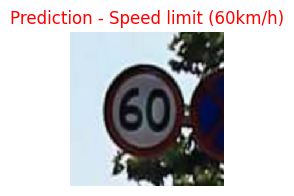

Predictions using model: Xception_saved


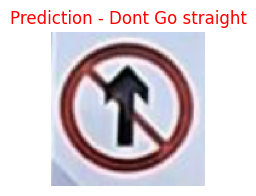

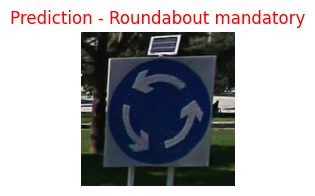

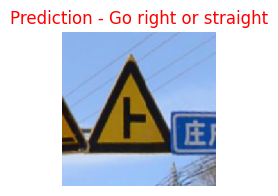

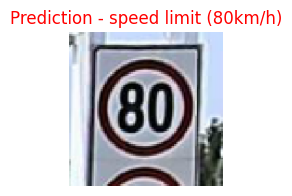

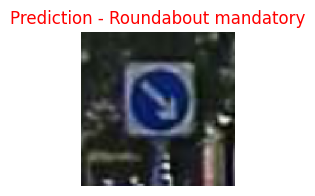

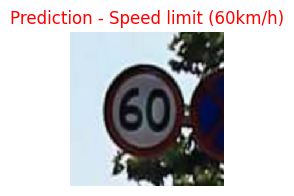

In [ ]:
import csv
import os
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/traffic_sign_dataset/traffic_Data/TEST/010_0012_j.png',
    '/content/traffic_sign_dataset/traffic_Data/TEST/027_1_0011_1_j.png',
    '/content/traffic_sign_dataset/traffic_Data/TEST/043_1_0025_1_j.png',
    '/content/traffic_sign_dataset/traffic_Data/TEST/007_0010_j.png',
    '/content/traffic_sign_dataset/traffic_Data/TEST/026_0036_j.png',
    '/content/traffic_sign_dataset/traffic_Data/TEST/005_1_0008_1_j.png'
]

def load_labels_mapping(labels_csv_path):
    classid_to_name = {}
    with open(labels_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            classid_to_name[row['ClassId']] = row['Name']
    return classid_to_name

def load_predicted_labels(model_name):
    predicted_labels = {}
    csv_file = f'/content/saved_models/predicted_{model_name}.csv'  # CSV file format
    with open(csv_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Label']
    return predicted_labels

def predict_image(filenames, predicted_labels, classid_to_name):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_id = predicted_labels[filename]
            predicted_class_name = classid_to_name.get(predicted_class_id, "Unknown")
        else:
            print("Filename not found :-")
            print(filename)
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Path to labels.csv
labels_csv_path = '/content/traffic_sign_dataset/labels.csv'

# Load the labels mapping
classid_to_name = load_labels_mapping(labels_csv_path)

# Directory containing the saved models and predicted CSV files
model_dir = '/content/saved_models'

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Determine the model name
        model_name = model_file.split('.')[0]

        # Load predicted labels from CSV file
        predicted_labels = load_predicted_labels(model_name)

        # Predict and plot images using predicted labels
        print(f"Predictions using model: {model_name}")
        predict_image(filenames, predicted_labels, classid_to_name)
